# **Post-processing technique: Equalised Odds Post-processing**

The Equalised Odds Post-Processing approach (Hardt et al 2016) flips predictions at random until a desired error rate distribution between the protected group and the rest of the sample is achieved. The steps we will take are outlined below.

1. First, we will calculate Disparate Impact and Statistical Parity Difference metrics for a baseline model with no fairness intervention.
2. We will then apply the Equalised Odds Post-processing method to data used to train a predictive model and observe the results.

# Install Libraries and load data

In [ ]:
# install AIF360
!pip install aif360
!pip install fairlearn

# import libraries
import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


Load the data into a dataframe using pickle.load

In [ ]:
# load data (amend this code to load the data from the correct file location)

with open(<file>, 'rb') as handle:
    df = pickle.load(handle)


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,Gender_Female,Gender_Male,Ethnicity_Asian,Ethnicity_Black,Ethnicity_Hispanic,Ethnicity_White,Action
0,28.021737,4.351153,2.453895,1.637143,-1.746628,-0.483463,0.034170,1.399225,-0.795440,0.417474,0.214564,-0.471581,1.945645,-0.676217,1.213878,0.015701,1.472670,-0.054158,0.106858,-1.073194,-1.071848,-0.249942,0.634626,-0.732358,2.445728,0.784284,0.112329,1.055362,-0.605459,1.259140,-0.287927,0.214142,-0.644585,1.165376,-0.409198,-0.705823,0.091147,-0.953603,0.979086,0.745246,...,-0.178814,-0.145229,-0.040692,-0.046980,0.311939,-0.348202,0.271357,0.355443,-0.050447,-0.051816,0.083028,0.184139,0.107824,-0.083415,-0.359288,0.156547,-0.588539,-0.025777,-0.172269,0.331421,0.222768,-0.319124,-0.060476,-0.557444,-0.015627,-0.052749,-0.234189,-0.072384,0.090403,0.376761,0.258914,-0.050558,0.014513,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,29.603342,-3.407193,0.771800,-2.957411,0.599226,-2.805277,0.329414,-2.055339,-1.194446,-0.633159,2.268302,1.159443,0.899266,-0.472739,0.541605,-1.248643,0.046512,1.225688,0.456477,-1.483071,-0.944882,1.483229,0.512809,0.692537,0.178988,-1.609531,-1.985852,-0.469491,-1.156583,0.475535,-0.041015,-0.214832,-0.681641,1.131433,-0.667814,0.267111,-0.112433,1.094115,0.647188,0.134436,...,-0.108402,0.027760,-0.015238,0.027453,0.319960,-0.014589,-0.083241,-0.285702,0.047510,-0.144107,0.405289,-0.044139,-0.287215,0.201876,-0.298703,0.347969,0.029646,0.073052,-0.010259,0.023681,0.373202,-0.525402,-0.198727,-0.198440,-0.158843,0.191984,-0.004532,0.229210,-0.173042,-0.072871,0.442939,-0.054423,0.026959,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,26.504283,0.642464,2.522944,-2.197094,2.270646,-0.472510,0.532815,-0.266449,-0.131638,1.038315,-0.865827,-0.811267,-0.381401,-0.801701,-0.485021,0.656005,2.489571,-0.714447,0.658228,-0.075957,-1.159888,-2.334786,-0.253364,-2.073697,-0.939994,-1.177166,0.551689,-1.313316,-0.486217,0.732130,-0.320456,-1.143053,1.297522,-0.617038,0.340978,0.978603,0.398515,0.068011,-0.156836,-0.995878,...,-0.101136,0.042583,0.061005,0.304137,0.259210,-0.022425,0.138097,-0.442536,-0.108350,0.369865,0.151049,0.096285,0.013651,0.175281,0.144344,-0.006250,0.100850,-0.051642,0.122977,-0.088661,-0.229844,-0.272144,0.012633,0.423352,-0.033844,-0.125387,-0.483924,-0.116553,-0.113281,0.015519,0.017111,-0.012309,0.264572,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,25.012088,0.895121,-2.092517,3.687830,0.539642,1.988930,1.121646,2.255337,-0.128801,1.148379,1.616247,-2.599757,-0.322807,2.102508,-0.204551,0.069818,0.745222,-0.859875,-2.235995,-0.207436,-1.678697,-0.569024,-0.723122,-0.144833,-1.537487,1.678429,0.501249,-0.230747,0.746559,-0.069959,-0.346651,0.448291,0.283592,-0.445759,-0.529080,0.287333,0.466766,-0.411191,0.158602,-0.112038,...,-0.092894,-0.009915,-0.031731,0.153983,0.001281,0.123019,-0.035719,-0.045633,-0.103204,0.089567,0.104990,0.337228,-0.018783,-0.215437,0.268139,-0.125425,0.095183,-0.125172,-0.226467,0.371647,-0.023041,-0.093040,0.338300,-0.280392,0.046582,0.116709,0.133876,0.072716,0.124083,0.213735,-0.149901,-0.217130,0.004403,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,27.358934,-2.332423,0.154999,-2.623793,1.682456,1.262280,-1.685565,0.489319,-0.043471,-0.372265,1.778535,-1.145419,2.461327,1.396318,-0.911969,-2.228570,1.378633,-1.512325,-0.440331,-0.111163,-0.885884,-0.840501,1.576620,-0.972075,-2.008346,-0.358732,0.896535,0.562193,0.154542,-1.077315,1.902062,1.728109,0.317205,-0.436143,0.226549,-0.502206,-0.157102,-0.858722,-0.537544,-0.715195,...,0.039836,-0.168277,0.077232,0.193722,0.093298,-0.075132,-0.063202,0.120167,0.039270,0.350429,0.166559,0.130134,-0.181019,-0.193276,0.312204,-0.187331,-0.029194,-0.212277,-0.463872,0.041810,0.041185,-0.182479,-0.182461,-0.019350,-0.093371,0.003443,-0.025467,0.155397,-0.067609,-0.084833,0.033429,-0.199198,0.229629,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,.

In [ ]:
# We scale the data as we are using logistic regression
scaler = StandardScaler()

df.iloc[:,:500] = scaler.fit_transform(df.iloc[:,:500])

# Run a baseline predictive model without applying post-processing
First we will build a Logistic Regression classifier and observe some baseline results, using the original data without Post-processing.

Set up variables for the privileged and unprivileged groups. In this example we will assign 'Ethnicity_White' as our privileged group. All other ethnicities are assigned as unprivileged.

Train a Logistic Regression model with 10 fold stratified cross validation. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Equalized Odds Difference, False Negative Rate Difference, Statistical Parity Difference).

To compute fairness metrics using AIF360, use the AIF360 documentation AIF360 for a [Binary Label Dataset](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.datasets.BinaryLabelDataset.html) and for a [Binary Label Dataset Metric](https://aif360.readthedocs.io/en/latest/modules/generated/aif360.metrics.BinaryLabelDatasetMetric.html)


In [ ]:
# Instantiate the classifier (this code is ready to run, there are no gaps to fill)
model = LogisticRegression(random_state=10, solver="lbfgs", penalty="none")

# instantiate the cross-validation scheme
mv = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# setup the performance metrics to be computed
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "F1-Score": metrics.f1_score, 
                }

# Set up variables for the privileged and unprivileged groups
prot = 'Ethnicity_White'
privileged_group = [{prot: 1}] 
unprivileged_group = [{prot: 0}]

In [ ]:
# Train a logistic regression classifier on the dataset (this code is ready to run, there are no gaps to fill)
k, i = True, 1

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for (train, test) in mv.split(X, y):

    # Create a Binary Label Dataset
    dataset = X.iloc[train].copy()
    dataset[df.columns[-1]] = y.iloc[train]
    dataset_BLD = BinaryLabelDataset(df=dataset, label_names=['Action'], protected_attribute_names=[prot])

    # instantiating X
    X_train = pd.DataFrame(data = dataset_BLD.features, columns=df.columns[:-1]) 

    # instantiating y
    y_train = pd.DataFrame(data = dataset_BLD.labels.ravel())

    # fit model
    model = model.fit(X_train, y_train)
    
    # get predictions in the test set
    ypred_class = model.predict(X.iloc[test])

    # compute performance metrics
    metrics = []
    dataset = X.iloc[test].copy()
    dataset[df.columns[-1]] = np.expand_dims(y.iloc[test], axis=1)
    dataset = BinaryLabelDataset(df=dataset, label_names=['Action'], protected_attribute_names=[prot])
    dataset_pred = X.iloc[test].copy()
    dataset_pred[df.columns[-1]] = np.expand_dims(ypred_class, axis=1)
    dataset_pred = BinaryLabelDataset(df=dataset_pred, label_names=['Action'], protected_attribute_names=[prot])
    metric_CM = ClassificationMetric(dataset, dataset_pred, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    for pf in perf_metrics.keys():
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]
    
    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', metric_CM.statistical_parity_difference()]]
    metrics += [['Equalized Odds Difference', metric_CM.average_odds_difference()]]
    metrics += [['False Negative Rate Difference', metric_CM.false_negative_rate_difference()]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics_orig = df_m.copy()
        k=0
    else:
        df_metrics_orig = pd.concat([df_metrics_orig, df_m.copy()], axis=0, ignore_index=True)

In [ ]:
# TODO: Display metrics

# /TODO

,mean,std
,Value,Value
Metric,,
Accuracy,0.712141,0.008402
Equalized Odds Difference,-0.058946,0.012744
F1-Score,0.593431,0.011609
False Negative Rate Difference,0.072792,0.023473
Precision,0.648655,0.013874
Recall,0.546962,0.012234
Statistical Parity Difference,-0.070907,0.010773


# Apply Equalised Odds Post-processing to the predictive model

Amend your Logistic Regression routine above to apply Post-Processing to each fold of training data.  Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Equalized Odds Difference, False Negative Rate Difference, Statistical Parity Difference)

In [ ]:
# TODO: Set up Equalised Odds Post-processing

# /TODO

k, i = True, 1

# instantiating X
X = df.drop(labels=df.columns[-1], axis=1)

# instantiating the target variable
y = df[df.columns[-1]]

for (train, test) in mv.split(X, y):

    # Set up the BinaryLabelDataset
    dataset = X.iloc[train].copy()
    dataset[df.columns[-1]] = y.iloc[train]
    dataset_BLD = BinaryLabelDataset(df=dataset, label_names=['Action'], protected_attribute_names=[prot])

    # instantiating X
    X_train = pd.DataFrame(data = dataset_BLD.features, columns=df.columns[:-1]) 

    # instantiating y
    y_train = pd.DataFrame(data = dataset_BLD.labels.ravel())

    # fit model
    model = model.fit(X_train, y_train)
    
    # get predictions in the test set
    X_test = X.iloc[test].copy()
    y_test = y.iloc[test].copy()
    ypred_prob = model.predict_proba(X_test).ravel()[1::2] # get probabilities
    ypred_class = model.predict(X_test)

    # TODO: fit post-processing using results from 60% of the test set

    # /TODO

    # TODO: post-process predictions on the other 40% of the test set

    # /TODO

    # compute performance metrics
    metrics = []
    metric_CM = ClassificationMetric(actuals_test_BLD, transf_pred_test_BLD, privileged_groups=privileged_group, unprivileged_groups=unprivileged_group)
    for pf in perf_metrics.keys():
            metrics += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class.ravel())]]
    
    # Compute fairness metrics
    metrics += [['Statistical Parity Difference', metric_CM.statistical_parity_difference()]]
    metrics += [['Equalized Odds Difference', metric_CM.average_odds_difference()]]
    metrics += [['False Negative Rate Difference', metric_CM.false_negative_rate_difference()]]

    # concatenate results
    df_m = pd.DataFrame(metrics, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

In [ ]:
# TODO: Display metrics

# /TODO

,mean,std
,Value,Value
Metric,,
Accuracy,0.712141,0.008402
Equalized Odds Difference,0.012185,0.039678
F1-Score,0.593431,0.011609
False Negative Rate Difference,-0.026073,0.072944
Precision,0.648655,0.013874
Recall,0.546962,0.012234
Statistical Parity Difference,-0.003707,0.034856


# Present results to show the effectiveness of the Post-processing method

Present graphs (bar charts work well) to show how each performance and fairness metric differs for the baseline model compared with the application of Post-processing. Show the target line for each metric on the graph.

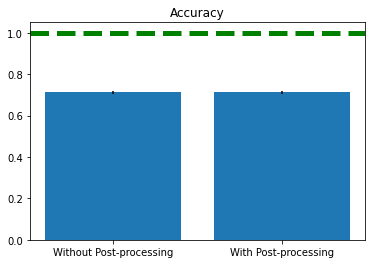

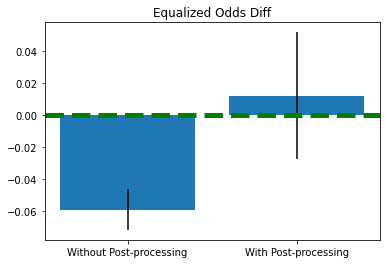

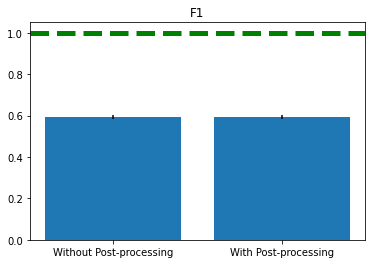

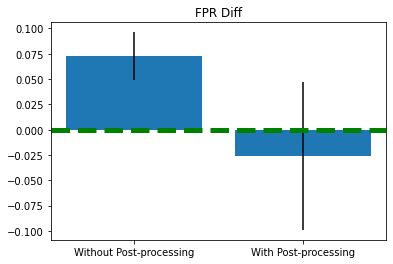

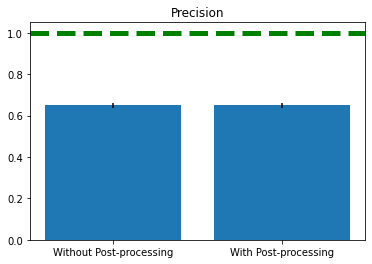

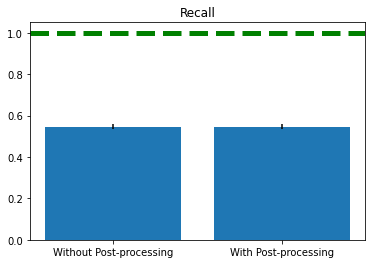

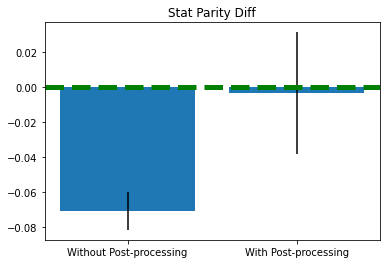

In [ ]:
# TODO: Present graphs to show each performance and fairness metrics

# /TODO
